<a href="https://colab.research.google.com/github/Murcha1990/AppliedDS_DPO_2024/blob/main/Lesson3_NLP3/AiEdu_LSTM_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Advanced: Making Dynamic Decisions and the Bi-LSTM CRF

## Динамические графы в PyTorch

В PyTorch графы динамические. Они строятся по ходу вычисления выражений. Чтобы повторить вычисления с новыми данными, необходимо повторно "пройти" по всем выражениям. Этот подход отличен от статических графов, которые строятся в tensorflow. Статический граф определяется один раз, компилируется и потом может произвольное число раз запускаться на вычисления с различными значениями в листовых узлах, но при этом не может быть изменён.

Без большого практического опыта трудно оценить
разницу между статическими и динамическими фреймворками.

Приведем пример - синтаксический анализатор текста. Предположим, что наша модель включает следующие
шаги:

* По тексту мы строим дерево
* Помечаем корневые узлы (слова предложения)
* На ребрах стоят связи между словами в предложении
* Затем используем нейронную сеть и эмбеддинги слов, чтобы решить задачу.

В этой задаче архитектура нашей сети полностью зависит от входного предложения. В предложении "Зеленая кошка поцарапала стену" получится одно дерево, а в предложении "Где-то большой толстый кот поцарапал
стену" - совершенно другое.

Если мы скомпилируем граф вычислений единожды, как в статическом фреймворке, то запрограммировать логику алгоритма будет крайне сложно или
невозможно. Однако в динамическом фреймворке для каждого объекта (текста) может быть создан новый граф вычислений, так что эта проблема исчезает.

## Bi-LSTM Conditional Random Field

В этом ноутбуке мы реализуем полноценную модель Bi-LSTM Conditional Random Field для задачи NER. Для задачи part-of-speech tagging достаточно обычной LSTM, но для распознавания именованных сущностей ключевым компонентом является именно CRF-часть модели.

Идея архитектуры состоит в следующем:

* При помощи LSTM мы извлекаем признаки из текстов
* На них обучаем Conditional Random Field для решения задачи NER

Напомним как работает CRF. CRF вычисляет условную вероятность.
Пусть $y$ - последовательность тегов, а $x$ - входная последовательность слов.

Вычислим

\begin{align}P(y|x) = \frac{\exp{(\text{Score}(x, y)})}{\sum_{y'} \exp{(\text{Score}(x, y')})}\end{align}

Score считается по некоторым лог-потенциалам:
$\log \psi_i(x,y):$

\begin{align}\text{Score}(x,y) = \sum_i \log \psi_i(x,y)\end{align}

В Bi-LSTM CRF мы используем два типа потенциалов: emission и
transition.
* Emission-потенциал для слова с индексом $i$ приходит из скрытого состояния ячейки Bi-LSTM на шаге $i$.

* Transition scores хранятся в $|T|x|T|$ матрице
$\textbf{P}$, где $T$ набор тэгов. В данной имплементации $\textbf{P}_{j,k}$ - это transition-score
в тэг $j$ из тэга $k$:

\begin{align}\text{Score}(x,y) = \sum_i \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)\end{align}

\begin{align}= \sum_i h_i[y_i] + \textbf{P}_{y_i, y_{i-1}}\end{align}

(у каждого тэга уникальный неотрицательный индекс).

## Заметки по имплементации

В этом ноутбуке мы реализуем forward-алгоритм в лог-пространстве, а также алгоритм Витерби для декодирования последовательности.

Для поиска параметров используется backpropagation.

In [ ]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

Далее описаны некоторые вспомогательные функции для улучшения читаемости кода.

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

## Создание модели

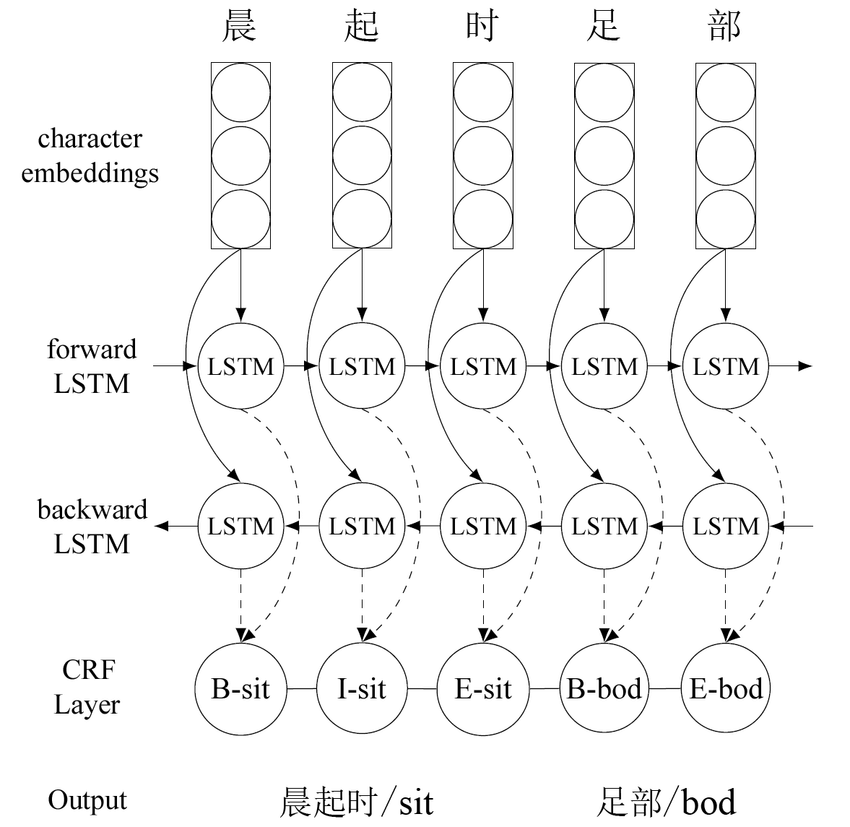

## Алгоритм декодирования Витерби

Алгоритм декодирования Витерби в марковских случайных полях применяется для нахождения наиболее вероятного пути (последовательности состояний) в системе с учетом наблюдаемых данных. Ниже приведен общий алгоритм Витерби для марковских случайных полей:

* Инициализация:
Задать начальные вероятности для каждого состояния в начальный момент времени.
Установить начальные значения для переменных, используемых в алгоритме.

* Рекурсивное вычисление вероятностей:
    Для каждого временного шага от второго до последнего:
        Для каждого состояния на текущем временном шаге:
            1. Вычислить вероятность наилучшего пути, достигнутого из предыдущего временного шага в текущее состояние.
            2. Сохранить указатель на предыдущее состояние для восстановления наилучшего пути.
        
*  Завершение:
На последнем временном шаге выбрать состояние с наивысшей вероятностью как конечное состояние наилучшего пути.
Сохранить указатели на предыдущие состояния для последующего восстановления пути.

*  Восстановление пути:
Используя сохраненные указатели, восстановить наилучший путь от последнего временного шага к начальному.


### Алгоритм Витерби: пример

Алгоритм декодирования Витерби может быть применен в задаче извлечения именованных сущностей (NER) для определения наиболее вероятной последовательности меток (таких как "Person", "Organization", "Location" и т. д.) для заданных входных данных. Давайте рассмотрим пример с числами в тексте.

Предположим, у нас есть следующий текст:
**"Вчера Петр встретил 5 человек в офисе Microsoft и обсудил проект."**

Пусть у нас есть три метки: "Person" (для имен), "Organization" (для организаций) и "Number" (для чисел). Мы хотим определить наилучшую последовательность меток для каждого слова в предложении.

* Инициализация:
Задаем начальные вероятности для каждой метки в начальном слове. Например, вероятность того, что первое слово - именованная сущность (Person), может быть высокой.

* Рекурсивное вычисление вероятностей:
Для каждого следующего слова в предложении:
    1. Вычисляем вероятности для каждой метки, учитывая вероятности предыдущих меток и параметры модели (вероятности переходов и наблюдений).
    2. Выбираем метку с наивысшей вероятностью для текущего слова.

* Завершение:
На последнем слове выбираем метку с наивысшей вероятностью в качестве конечной метки.

* Восстановление пути:
Используя сохраненные наилучшие метки для каждого слова, восстанавливаем последовательность меток от начала до конца предложения.

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats): # CRF-part
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags): # forward-path + loss-calculation
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats) # score from model
        gold_score = self._score_sentence(feats, tags) # ideal score (from true target)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

## Запуск обучения

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4

# Make up some training data
training_data = [(
    "the wall street journal reported today that apple corporation made money".split(),
    "B I I I O O O B I O O".split()
), (
    "georgia tech is a university in georgia".split(),
    "B I O O O O B".split()
)]

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))
# We got it!

(tensor(2.6907), [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
(tensor(20.4906), [0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2])
